In [114]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.interpolate import interp1d

from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

update_matplotlib_rc()
figsize = figure_size(252 * 1.0, 1.0)

In [115]:
class Experiment:
    # task = "navalpropulsion"
    # task = "parkinsonstelemonitoring"
    # task = "proteinstructure"
    task = "slicelocalization"
    problem = "dhexp.benchmark.hpobench_tabular"
    search = "RANDOM"
    stopper = None
    stopper_args = None
    max_evals = 200
    max_budget = 100
    random_state = None

    def __init__(self, stopper, stopper_args, random_state) -> None:
        self.stopper = stopper
        self.stopper_args = stopper_args
        self.random_state = random_state

    @property
    def log_dir(self):
        return f"{self.task}/output/{self.problem}-{self.search}-{self.stopper}-{self.stopper_args}-{self.max_evals}-{self.random_state}"

    @property
    def path_results(self):
        return os.path.join(self.log_dir, "results.csv")

    def load_results(self):
        return pd.read_csv(self.path_results, index_col=None)

In [116]:
import itertools

random_states = "1608637542 3421126067 4083286876  787846414 3143890026 3348747335 2571218620 2563451924  670094950 1914837113".split()

# Trajectories
# map_stopper_to_args = {
#     "deephyper.stopper.ConstantStopper": "1 100".split(),
#     "deephyper.stopper.SuccessiveHalvingStopper": "64 1.19".split(),
#     "deephyper.stopper.LCModelStopper.pow3": "0.5 0.95".split(),
#     "deephyper.stopper.LCModelStopper.mmf4": "0.5 0.95".split(),
#     "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "0.5 0.95".split(),
# }

# Pareto-Front
map_stopper_to_args = {
    "deephyper.stopper.ConstantStopper": "1 2 3 4 5 10 15 20 25 50 75 100".split(),
    "deephyper.stopper.SuccessiveHalvingStopper": "64 32 16 8 4 2 1.41 1.19".split(),
    "deephyper.stopper.LCModelStopper.pow3": "0.5 0.7 0.8 0.9 0.95".split(),
    "deephyper.stopper.LCModelStopper.mmf4": "0.5 0.7 0.8 0.9 0.95".split(),
    "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "0.5 0.7 0.8 0.9 0.95".split(),
}

topk_ = 3
map_stopper_to_topk = {k: topk_ for k in map_stopper_to_args.keys()}

# map_stopper_to_linestyle = {
#     "deephyper.stopper.ConstantStopper": "-",
#     "deephyper.stopper.SuccessiveHalvingStopper": "--",
#     "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "-",
# }

linestyle_list = {
    i: v
    for i, v in enumerate(
        [
            "-",
            "--",
            ":",
        ]
    )
}

map_stopper_to_letter = {
    "deephyper.stopper.ConstantStopper": "$i$",
    "deephyper.stopper.SuccessiveHalvingStopper": "$r$",
    "deephyper.stopper.LCModelStopper.pow3": "$\\rho$",
    "deephyper.stopper.LCModelStopper.mmf4": "$\\rho$",
    "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "$\\rho$",
}

map_stopper_to_color = {
    "deephyper.stopper.ConstantStopper": "C3",
    "deephyper.stopper.SuccessiveHalvingStopper": "C1",
    "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "C0",
    "deephyper.stopper.LCModelStopper.pow3": "C4",
    "deephyper.stopper.LCModelStopper.mmf4": "C2",
}

map_stopper_to_label = {
    "deephyper.stopper.ConstantStopper": "Epoch-{}",
    "deephyper.stopper.SuccessiveHalvingStopper": "SHA-{}",
    "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": "PFN-{}",
    "deephyper.stopper.LCModelStopper.pow3": "POW3-{}",
    "deephyper.stopper.LCModelStopper.mmf4": "LCE-{}",
}

data = {
    "deephyper.stopper.SuccessiveHalvingStopper": {},
    "deephyper_benchmark.stopper.lcpfn.LCPFNStopper": {},
    # "deephyper.stopper.LCModelStopper.pow3": {},
    "deephyper.stopper.LCModelStopper.mmf4": {},
    "deephyper.stopper.ConstantStopper": {},
}


for stopper, stopper_items in data.items():
    for stopper_args, random_state in itertools.product(
        map_stopper_to_args[stopper], random_states
    ):
        exp = Experiment(stopper, stopper_args, random_state)
        df = exp.load_results()
        dfs = stopper_items.get(stopper_args, [])
        dfs.append(df)
        stopper_items[stopper_args] = dfs

In [117]:
from collections import deque

def process(df, mode="max", topk_tournament=None, filter_duplicates=False, max_budget=100):
    assert mode in ["min", "max"]
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            fdf = df[:i+1]
            
            if filter_duplicates:
                fdf = fdf.drop_duplicates([pname for pname in df.columns if "p:" in pname], keep="last")
                
            if mode == "max":
                topk = fdf[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = fdf[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            for topk_i in range(min(len(topk), k)):
                budget = topk.iloc[topk_i]["m:budget"]
                # retraining cost if not completed
                if budget < max_budget:
                    df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + max_budget
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
            
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        for idx in df["max_idx"]:
            if df.loc[idx, "m:budget"] < max_budget:
                df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + max_budget
                
    return df

In [118]:
max_evals = exp.max_evals
max_budget = exp.max_budget
plot_val = False
plot_pf = True
plot_regret = True

deephyper.stopper.SuccessiveHalvingStopper 64
deephyper.stopper.SuccessiveHalvingStopper 32
deephyper.stopper.SuccessiveHalvingStopper 16
deephyper.stopper.SuccessiveHalvingStopper 8
deephyper.stopper.SuccessiveHalvingStopper 4
deephyper.stopper.SuccessiveHalvingStopper 2
deephyper.stopper.SuccessiveHalvingStopper 1.41
deephyper.stopper.SuccessiveHalvingStopper 1.19
deephyper_benchmark.stopper.lcpfn.LCPFNStopper 0.5
deephyper_benchmark.stopper.lcpfn.LCPFNStopper 0.7
deephyper_benchmark.stopper.lcpfn.LCPFNStopper 0.8
deephyper_benchmark.stopper.lcpfn.LCPFNStopper 0.9
deephyper_benchmark.stopper.lcpfn.LCPFNStopper 0.95
deephyper.stopper.LCModelStopper.mmf4 0.5
deephyper.stopper.LCModelStopper.mmf4 0.7
deephyper.stopper.LCModelStopper.mmf4 0.8
deephyper.stopper.LCModelStopper.mmf4 0.9
deephyper.stopper.LCModelStopper.mmf4 0.95
deephyper.stopper.ConstantStopper 1
deephyper.stopper.ConstantStopper 2
deephyper.stopper.ConstantStopper 3
deephyper.stopper.ConstantStopper 4
deephyper.stopper.Co

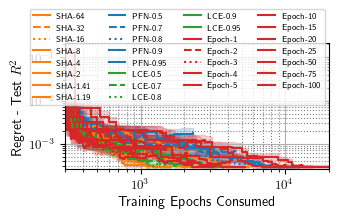

In [119]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

data_y_final = {k: [] for k in data.keys()}

plt.figure(figsize=figsize)

pf_x = []
pf_y = []

y_max_all = -np.inf
y_min_all = np.inf

for i, (stopper, stopper_items) in enumerate(data.items()):
    for j, (stopper_args, dfs) in enumerate(stopper_items.items()):
        print(stopper, stopper_args)
        color = map_stopper_to_color.get(stopper, cmap(i))
        linestyle = linestyle_list.get(j, "-")

        x_space = np.arange(max_budget, max_evals * max_budget + 1)
        dfs_processed = map(
            lambda x: process(
                x,
                mode="max",
                topk_tournament=map_stopper_to_topk[stopper],
                max_budget=max_budget,
            ),
            dfs,
        )
        x_list = []
        y_list = []
        for j, df in enumerate(dfs_processed):
            x = df["m:budget_cumsum"].to_numpy()

            if plot_val:
                y = df.loc[df["max_idx"]]["m:objective_val"].values
            else:
                y = df.loc[df["max_idx"]]["m:objective_test"].values

            x_list.append(x)
            y_list.append(y)

        x_list = np.asarray(x_list)
        y_list = np.asarray(y_list)

        x_mean = np.mean(x_list, axis=0)
        x_stde = np.std(x_list, axis=0) / np.sqrt(x_list.shape[0])

        # regret
        if plot_regret:
            y_list = 1 - y_list
        y_mean = np.mean(y_list, axis=0)

        y_stde = np.std(y_list, axis=0) / np.sqrt(y_list.shape[0])
        y_min = y_mean - y_stde
        y_max = y_mean + y_stde

        mask = x_mean >= max_budget * 3
        y_max_all = max(y_max_all, np.max(y_max[mask]))
        y_min_all = min(y_min_all, np.min(y_min[mask]))

        data_y_final[stopper].append([x_mean[-1], y_mean[-1], x_stde[-1], y_stde[-1]])

        plt.step(
            x_mean,
            y_mean,
            # linestyle=map_stopper_to_linestyle[stopper],
            linestyle=linestyle,
            color=color,
            label=f"{map_stopper_to_label[stopper].format(stopper_args)}",
        )
        plt.fill_between(
            x_mean,
            y_min,
            y_max,
            step="pre",
            alpha=0.2,
            color=color,
        )

        # for i, y in enumerate(y_list):
        #     plt.plot(x, y, label=f"{i}")

plt.xlabel("Training Epochs Consumed")
if plot_val:
    plt.ylabel("Regret - Validation $R^2$")
else:
    plt.ylabel("Regret - Test $R^2$")
plt.xlim(max_budget * 3, max_budget * max_evals)
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
# plt.legend(ncol=3, fontsize=7)
# plt.legend(ncol=3, fontsize=7, loc="upper right")
ax = plt.gca()
h, l = ax.get_legend_handles_labels()
# h, l = h[:4], l[:4]
# h, l = h[6:], l[6:]
plt.legend(handles=h, labels=l, ncol=4, loc="upper right", bbox_to_anchor=(1.0, 1.3), fontsize=6)
plt.xscale("log")
plt.yscale("log")

plt.ylim(y_min_all, y_max_all)

if not (plot_pf):
    if plot_val:
        plt.savefig(
            os.path.join(exp.task, "curves_log_val.jpg"), dpi=300, bbox_inches="tight"
        )
    else:
        plt.savefig(
            os.path.join(exp.task, "curves_log_test.jpg"), dpi=300, bbox_inches="tight"
        )
plt.show()

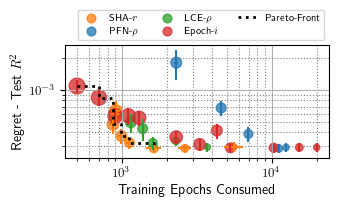

In [120]:
from deephyper.skopt.moo import pareto_front

y_all = []

plt.figure(figsize=figsize)

for i, (stopper, y) in enumerate(data_y_final.items()):
    y = np.array(y)
    y_all.extend(y[:,:2])
    pf, pf_idx = pareto_front(y[:,:2], sort=True, return_idx=True)
    parameters = map_stopper_to_args[stopper]
    s = (len(parameters) - np.arange(len(parameters))+1)*10
    # s = (10 - np.arange(len(parameters))+1)*15
    plt.scatter(y[:, 0], y[:, 1], color=map_stopper_to_color[stopper], label=map_stopper_to_label[stopper].format(map_stopper_to_letter[stopper]), alpha=0.75, s=s)
    plt.errorbar(y[:, 0], y[:, 1], xerr=y[:,2:3].reshape(-1), yerr=y[:, 3:4].reshape(-1), color=map_stopper_to_color[stopper], linestyle="none", marker="none", )

y_all = np.array(y_all)
pf = pareto_front(y_all, sort=True)

plt.step(
    pf[:, 0],
    pf[:, 1],
    color="black",
    linewidth=2,
    linestyle=":",
    where="post",
    label="Pareto-Front",
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Training Epochs Consumed")
if plot_val:
    plt.ylabel("Regret - Validation $R^2$")
else:
    plt.ylabel("Regret - Test $R^2$")
lgnd = plt.legend(ncol=3, loc="upper right", bbox_to_anchor=(1.0, 1.35))
for i in range(len(lgnd.legend_handles)):
    lgnd.legend_handles[i]._sizes = [40]
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
if plot_pf:
    plt.savefig(os.path.join(exp.task, "pf.jpg"), dpi=300, bbox_inches="tight")
plt.show()